# M06. Pulls
- This predicts when starting pitchers are removed from a game
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB Stats API
    - Steamer
- Created: 11/1/2023
- Updated: 2/1/2025

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Functions.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"

### Data

##### Park x Weather Factors

In [2]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Park and Weather Factors.csv"))

##### Plate Appearances

In [3]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Final Dataset.csv"))

### Adjust

In the model, pulls occur before the PA, not after, so innings and outs need to be adjusted

In [4]:
complete_dataset['inning_adj'] = complete_dataset['inning'] + (complete_dataset['outs'] == 3).astype(int)
complete_dataset['outs_adj'] = complete_dataset['outs'] * (complete_dataset['outs'] != 3).astype(int)

To account for the inning shift, inning stat sums should be reset

In [5]:
for variable in events_list + ['faced', 'reached', 'outs_pa']:
    complete_dataset[f'{variable}_inning_adj'] = np.where(complete_dataset['outs'] == 3, 0, complete_dataset[f'{variable}_inning']) 
    complete_dataset[f'{variable}_game_adj'] = complete_dataset[f'{variable}_game'].copy()

To match the model, imputation flags should be determined at the beginning of the game 

In [6]:
complete_dataset['imp_p_adj'] = complete_dataset.groupby(['gamePk', 'pitcher'])['imp_p'].transform('max')

In [7]:
# complete_dataset.query('gamePk == 413661')[['date', 'atBatIndex', 'halfInning', 'inning', 'outs', 'inning_adj', 'outs_adj', 'outs_pa', 'outs_pre',
#                                             'pitchHand', 'batSide', 'pitcherName', 'batterName', 'eventsModel', 
#                                             'faced_inning', 'faced_game', 'faced_inning_adj', 'b1_inning', 'b1_inning_adj', 'imp_p_adj', 'pulled']].head(10)

### Steamer

In [8]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

### Merge

Format dates

In [9]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

Remove missing pitchers (occurs occassionally in 2014)

In [10]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['mlbamid'].isna()]

Set data types

In [11]:
complete_dataset['pitcher'] =complete_dataset['pitcher'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['mlbamid'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [12]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher', 
    suffixes=('', '_fg'),
    direction='backward' 
)

### Select Data 

Only keep one observation per at bat

In [13]:
complete_merged_df.drop_duplicates(subset=['date', 'gamePk', 'atBatIndex'], keep='last', inplace=True)

Keep those with reasonable IP/start projections 

In [14]:
complete_merged_df = complete_merged_df.query('IP_start > 3 and IP_start < 8')

Only keep starting pitchers

In [15]:
complete_merged_df = complete_merged_df[complete_merged_df['starter'] == 1]

Drop early observations

In [16]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2024-01-01']

Inning dummies

In [17]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning_adj'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning_adj'] >= 11).astype(int)

In [18]:
inning_dummy_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]
inning_dummy_list.remove('inning_adj')

Out dummies

In [19]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_adj'] == out).astype(int)

In [20]:
out_dummy_list = ['outs_0', 'outs_1', 'outs_2']

Cumulative variables

In [21]:
cumulative_inning_list = [col for col in complete_merged_df.columns if col.endswith("_inning_adj")]

Exclude outs recorded by the pitcher that inning (redudant with inning dummies for starting pitchers)

In [22]:
cumulative_inning_list.remove('outs_pa_inning_adj')

In [23]:
cumulative_game_list = [col for col in complete_merged_df.columns if col.endswith("_game_adj")]

Game state variables

In [24]:
game_state_list = ['pitcherScore', 'batterScore', 'onFirst', 'onSecond', 'onThird']

Steamer variables

In [25]:
steamer_list = ['IP_start']

Imputation dummy

In [26]:
imp_list = ['imp_p_adj']

In [27]:
pull_inputs = cumulative_inning_list + cumulative_game_list + inning_dummy_list + out_dummy_list + game_state_list + steamer_list + imp_list

In [28]:
pull_inputs = [
 'faced_inning_adj',
 'reached_inning_adj',
 'faced_game_adj',
 'reached_game_adj',
 'outs_pa_game_adj',
 'inning_1',
 'inning_2',
 'inning_3',
 'inning_4',
 'inning_5',
 'inning_6',
 'inning_7',
 'inning_8',
 'inning_9',
 'inning_10',
 'inning_11',
 'outs_0',
 'outs_1',
 'outs_2',
 'pitcherScore',
 'batterScore',
 'onFirst',
 'onSecond',
 'onThird',
 'IP_start',
 'imp_p_adj']

### Train/Test Split

Split the data both on "pulled" and "imp_p_adj" to ensure training and test datasets are most similar

In [29]:
def balanced_split(df, stratify_cols, random_state=42):
    """
    Creates a 'split' column ensuring an even, random balance for the given stratification columns.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        stratify_cols (list): List of columns to balance the split on.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: Updated dataframe with a 'split' column (0 for training, 1 for test).
    """
    np.random.seed(random_state)  # Set seed for reproducibility
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle before splitting

    split_values = []
    
    for _, group in df.groupby(stratify_cols):
        n = len(group)
        half_n = n // 2  # Ensure a 50-50 split

        split_vals = np.array([0] * half_n + [1] * (n - half_n))  # Split evenly
        np.random.shuffle(split_vals)  # Randomize within the group

        split_values.extend(split_vals)

    df['split'] = split_values
    return df

In [30]:
complete_merged_df = balanced_split(complete_merged_df, stratify_cols=['pulled', 'imp_p_adj'], random_state=100)

In [31]:
training_dataset = complete_merged_df[complete_merged_df['split'] == 0].drop('split', axis=1)
testing_dataset = complete_merged_df[complete_merged_df['split'] == 1].drop('split', axis=1)

In [32]:
testing_dataset.reset_index(inplace=True, drop=True)

In [33]:
complete_merged_df['IP_start'].describe()

count    179154.000000
mean          5.664360
std           0.240048
min           5.007500
25%           5.504819
50%           5.674968
75%           5.785859
max           7.765000
Name: IP_start, dtype: float64

### Model

In [34]:
%%time
pulls_filename = f"predict_pulls_{todaysdate}.sav"
print(pulls_filename)

random_state = 100
layers = (32,16)
# layers = (100)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+1, early_stopping=True, max_iter=100),  
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+2, early_stopping=True, max_iter=100),  
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+3, early_stopping=True, max_iter=100),  
    ]

# Create the ensemble classifier using VotingClassifier
model_pulls = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(training_dataset[pull_inputs], training_dataset[['pulled']].values.ravel())

# Save model
pickle.dump(model_pulls, open(os.path.join(model_path, "M06. Pulls", pulls_filename), 'wb'))

predict_pulls_20250817.sav
CPU times: total: 266 ms
Wall time: 15.2 s


In [35]:
# Make predictions
proba = model_pulls.predict_proba(testing_dataset[pull_inputs])
testing_dataset['is_kept_pred'] = proba[:, 0]  # Assign the first column of probabilities
testing_dataset['is_pulled_pred'] = proba[:, 1]  # Assign the second column of probabilities

### Graph

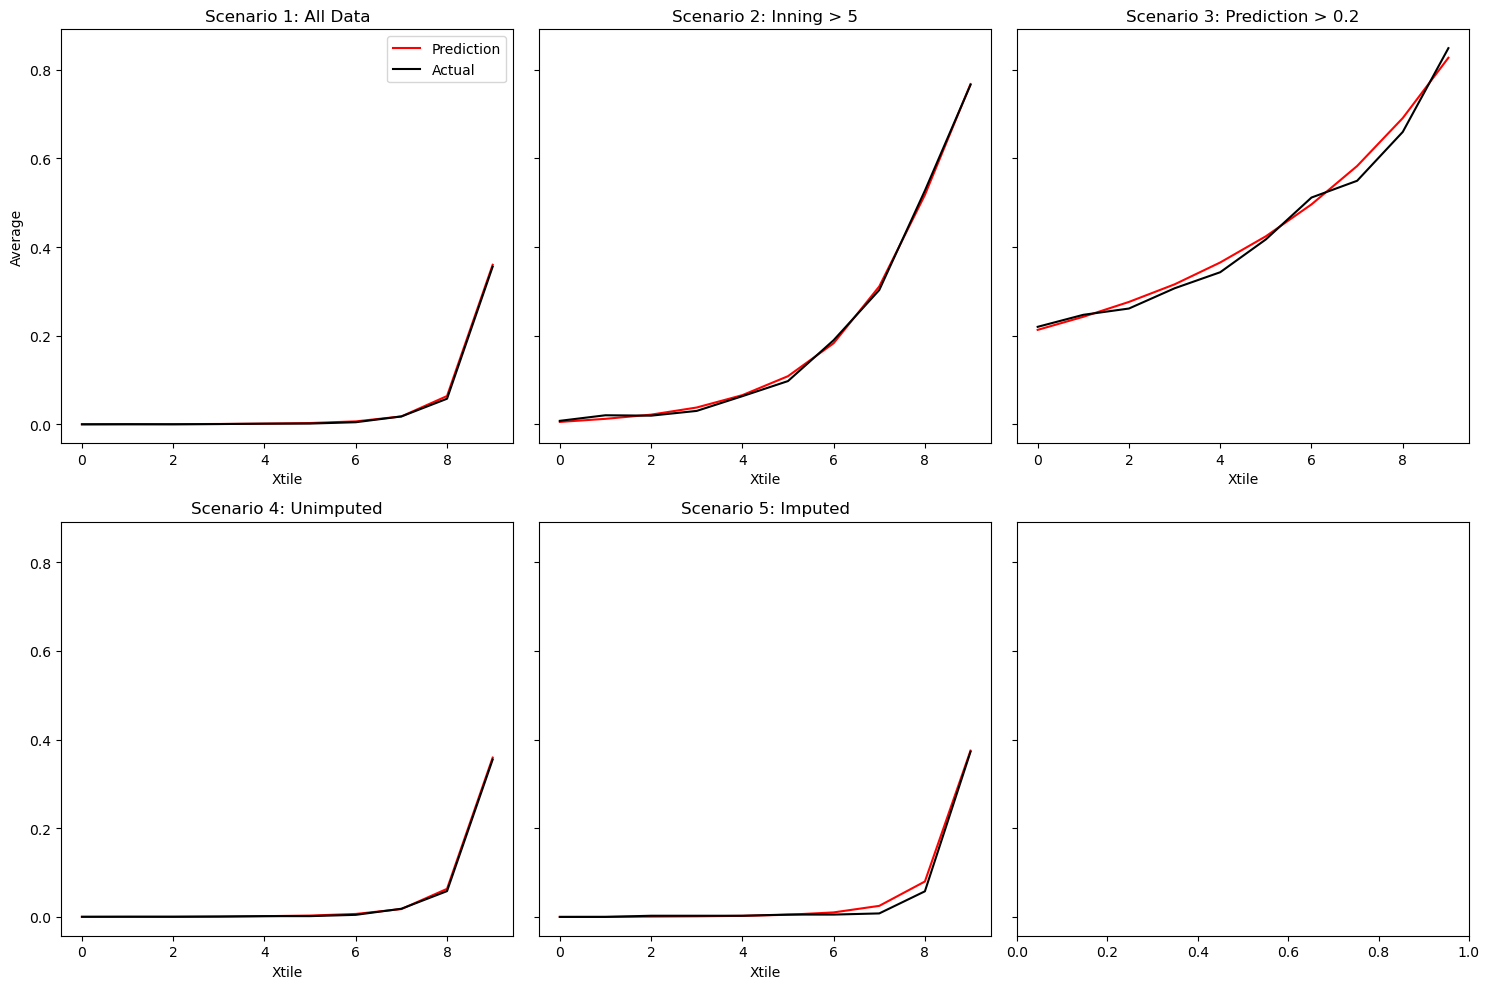

In [36]:
xtiles = 10

# First Scenario
testing_dataset['xtile1'] = pd.qcut(testing_dataset['is_pulled_pred'], xtiles, labels=False)
is_pulled_df1 = testing_dataset.groupby('xtile1')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Second Scenario
testing_dataset['xtile2'] = pd.qcut(testing_dataset.query('inning > 5')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df2 = testing_dataset.query('inning > 5').groupby('xtile2')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Third Scenario
testing_dataset['xtile3'] = pd.qcut(testing_dataset.query('is_pulled_pred > 0.2')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df3 = testing_dataset.query('is_pulled_pred > 0.2').groupby('xtile3')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Unimputed
testing_dataset['xtile4'] = pd.qcut(testing_dataset.query('imp_p_adj == 0')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df4 = testing_dataset.query('imp_p_adj == 0').groupby('xtile4')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Imputed
testing_dataset['xtile5'] = pd.qcut(testing_dataset.query('imp_p_adj == 1')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df5 = testing_dataset.query('imp_p_adj == 1').groupby('xtile5')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Create a figure with 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)



# Plot each graph
axes[0,0].plot(is_pulled_df1['xtile1'], is_pulled_df1['is_pulled_pred'], color='red', label='Prediction')
axes[0,0].plot(is_pulled_df1['xtile1'], is_pulled_df1['pulled'], color='black', label='Actual')
axes[0,0].set_title('Scenario 1: All Data')
axes[0,0].set_xlabel('Xtile')
axes[0,0].set_ylabel('Average')

axes[0,1].plot(is_pulled_df2['xtile2'], is_pulled_df2['is_pulled_pred'], color='red', label='Prediction')
axes[0,1].plot(is_pulled_df2['xtile2'], is_pulled_df2['pulled'], color='black', label='Actual')
axes[0,1].set_title('Scenario 2: Inning > 5')
axes[0,1].set_xlabel('Xtile')

axes[0,2].plot(is_pulled_df3['xtile3'], is_pulled_df3['is_pulled_pred'], color='red', label='Prediction')
axes[0,2].plot(is_pulled_df3['xtile3'], is_pulled_df3['pulled'], color='black', label='Actual')
axes[0,2].set_title('Scenario 3: Prediction > 0.2')
axes[0,2].set_xlabel('Xtile')

axes[1,0].plot(is_pulled_df4['xtile4'], is_pulled_df4['is_pulled_pred'], color='red', label='Prediction')
axes[1,0].plot(is_pulled_df4['xtile4'], is_pulled_df4['pulled'], color='black', label='Actual')
axes[1,0].set_title('Scenario 4: Unimputed')
axes[1,0].set_xlabel('Xtile')

axes[1,1].plot(is_pulled_df5['xtile5'], is_pulled_df5['is_pulled_pred'], color='red', label='Prediction')
axes[1,1].plot(is_pulled_df5['xtile5'], is_pulled_df5['pulled'], color='black', label='Actual')
axes[1,1].set_title('Scenario 5: Imputed')
axes[1,1].set_xlabel('Xtile')

# Add a legend to the first plot
axes[0,0].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


In [37]:
testing_dataset.query('inning > 5').groupby('imp_p_adj')[['pulled', 'is_pulled_pred']].mean()

,pulled,is_pulled_pred
imp_p_adj,,
0,0.202499,0.202163
1,0.211111,0.249648


In [38]:
testing_dataset.query('year >= 2024').query('inning > 5').groupby('imp_p_adj')[['pulled', 'is_pulled_pred']].mean()

,pulled,is_pulled_pred
imp_p_adj,,
0,0.202499,0.202163
1,0.211111,0.249648


In [39]:
(
    testing_dataset
    .query("year >= 2024 and inning > 0")
    .assign(inning_group=lambda df: df["inning"].sub(1).clip(lower=0))  # makes 0,1,2,...
    .groupby(["imp_p_adj", "inning_group"])[["pulled", "is_pulled_pred"]]
    .mean()
)


pulled  is_pulled_pred
imp_p_adj inning_group                          
0         0             0.001624        0.001034
          1             0.002953        0.003769
          2             0.008146        0.010144
          3             0.024067        0.025279
          4             0.079953        0.084146
          5             0.180068        0.183989
          6             0.262678        0.254725
          7             0.261838        0.217229
          8             0.240385        0.254501
1         0             0.001236        0.001774
          1             0.003741        0.009100
          2             0.013831        0.025370
          3             0.044223        0.048100
          4             0.142857        0.123141
          5             0.200893        0.238300
          6             0.263158        0.310712
          7             0.285714        0.312703
          8             0.000000        0.029834